# 1. Required Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from collections import defaultdict

# Using OpenAI's embedding model this time. 

# 2. Harmonic Wave Function

In [2]:
def harmonic_wave(params, t, batch_size):
    """
    Generate a harmonic wave based on parameters.
    Handles batch processing for multiple embeddings.
    """
    harmonics = []
    for i in range(batch_size):
        amplitudes, frequencies, phases = np.split(params[i], 3)
        harmonic = (
            amplitudes[:, None] * np.sin(2 * np.pi * frequencies[:, None] * t + phases[:, None])
        )
        harmonics.append(harmonic.sum(axis=0))
    return np.vstack(harmonics)

# 3. Generate Embeddings


In [3]:
from transformers import AutoTokenizer, AutoModel

# Load transformer model and tokenizer
model_name = "bert-base-uncased"  # Replace with desired transformer model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Generate embeddings
def generate_embeddings(texts):
    """
    Generate embeddings for a list of texts using a pretrained transformer.
    Returns: numpy array of shape (num_texts, embedding_dim)
    """
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        outputs = model(**inputs)
        # Use the CLS token embedding as the representation
        cls_embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

# Example texts
texts = [
    "The quick brown fox jumps over the lazy dog.",
    "AI is transforming the world of technology.",
    "Deep learning enables powerful language models."
]

# Generate embeddings
embeddings = generate_embeddings(texts)

# 4. Map Embeddings to Harmonics 

In [4]:
def map_embeddings_to_harmonics(embeddings):
    """
    Initialize harmonic parameters for all embeddings in a batch.
    """
    batch_size, embedding_dim = embeddings.shape
    params = []
    for i in range(batch_size):
        params.append(np.random.rand(3 * embedding_dim))  # Amplitudes, Frequencies, Phases
    return np.vstack(params)

# 5. Train the Harmonic System

In [5]:
def loss_function(params, t, target_embedding):
    """
    Compute the loss between the target embedding and the generated harmonic wave.
    Uses Mean Squared Error (MSE) as the metric.
    """
    # Generate harmonic wave for the given parameters
    amplitudes, frequencies, phases = np.split(params, 3)
    harmonic = (
        amplitudes[:, None] * np.sin(2 * np.pi * frequencies[:, None] * t + phases[:, None])
    ).sum(axis=0)
    
    # Compute MSE loss
    loss = ((target_embedding - harmonic) ** 2).mean()
    return loss


def compute_gradients(params, t, target_embedding, epsilon=1e-5):
    """
    Compute numerical gradients for the harmonic parameters using finite differences.
    """
    gradients = np.zeros_like(params)
    for i in range(len(params)):
        params_step = params.copy()
        
        # Positive perturbation
        params_step[i] += epsilon
        loss_plus = loss_function(params_step, t, target_embedding)
        
        # Negative perturbation
        params_step[i] -= 2 * epsilon
        loss_minus = loss_function(params_step, t, target_embedding)
        
        # Compute gradient
        gradients[i] = (loss_plus - loss_minus) / (2 * epsilon)
    return gradients


def train_harmonic_embeddings(embeddings, t, batch_size, learning_rate=0.01, epochs=100):
    """
    Train harmonic wave parameters to match transformer embeddings.
    Handles multiple embeddings in batch.
    """
    params = map_embeddings_to_harmonics(embeddings)  # Random initialization
    for epoch in range(epochs):
        total_loss = 0
        for i in range(batch_size):
            # Compute loss
            loss = loss_function(params[i], t, embeddings[i])
            
            # Compute gradients
            gradients = compute_gradients(params[i], t, embeddings[i])
            
            # Update parameters
            params[i] -= learning_rate * gradients
            
            # Accumulate loss
            total_loss += loss
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / batch_size}")
    return params

# 6. Visualize results

In [6]:
# Visualize embeddings vs harmonic waves
def visualize_embeddings(target, learned):
    """
    Visualize target embeddings and learned harmonic embeddings.
    """
    plt.figure(figsize=(12, 6))

    # Plot target embeddings
    plt.subplot(211)
    plt.imshow(target, aspect="auto", cmap="viridis")
    plt.title("Target Embeddings")
    plt.colorbar()

    # Plot learned harmonic embeddings (reshaped)
    plt.subplot(212)
    plt.imshow(learned, aspect="auto", cmap="viridis")
    plt.title("Learned Harmonic Embeddings")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

# 7. Putting it all together

Epoch 1/100, Loss: 9096.906626485828
Epoch 2/100, Loss: 168.89404938800683
Epoch 3/100, Loss: 117.93028251410271
Epoch 4/100, Loss: 94.49550229759006
Epoch 5/100, Loss: 129.2231132012918
Epoch 6/100, Loss: 58.12848301514018
Epoch 7/100, Loss: 94.21831380368407
Epoch 8/100, Loss: 64.69755571397596
Epoch 9/100, Loss: 85.58195466963706
Epoch 10/100, Loss: 55.84155157209409
Epoch 11/100, Loss: 48.35908171721069
Epoch 12/100, Loss: 63.31697343285597
Epoch 13/100, Loss: 37.94011414684311
Epoch 14/100, Loss: 44.86558124663344
Epoch 15/100, Loss: 19.166250385966862
Epoch 16/100, Loss: 54.04974495191622
Epoch 17/100, Loss: 43.529598706461854
Epoch 18/100, Loss: 32.488504534888385
Epoch 19/100, Loss: 35.57587534489633
Epoch 20/100, Loss: 38.478544212636514
Epoch 21/100, Loss: 38.53913515938927
Epoch 22/100, Loss: 28.898241693967126
Epoch 23/100, Loss: 27.364481441953814
Epoch 24/100, Loss: 28.850873331299667
Epoch 25/100, Loss: 31.530594892192028
Epoch 26/100, Loss: 26.80523973983064
Epoch 27/10

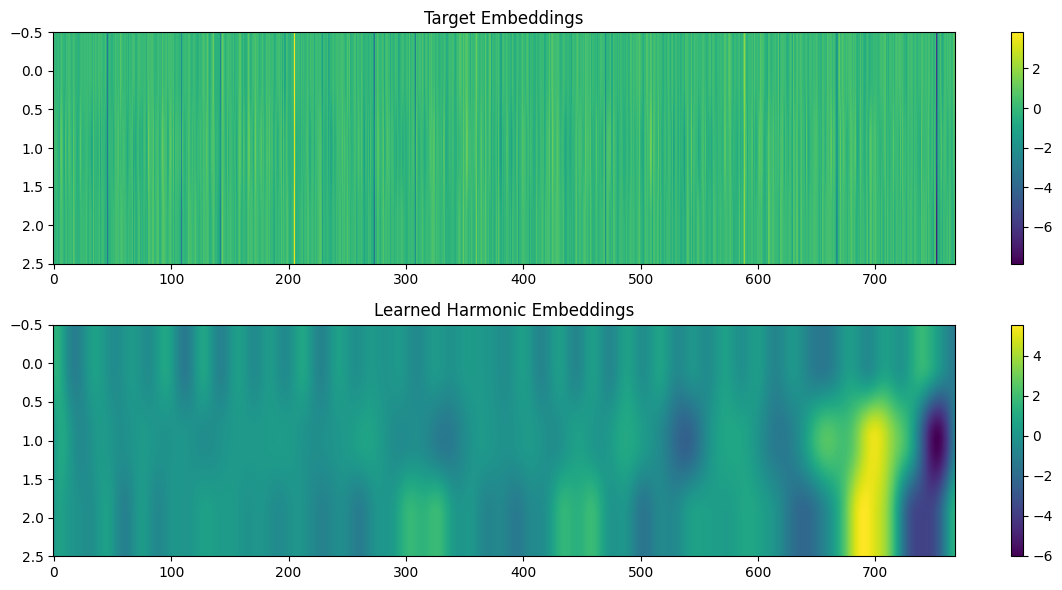

In [7]:
# Generate time steps
t = np.linspace(0, 5, embeddings.shape[1])  # Adjust as needed for your embeddings

# Train harmonic embeddings
batch_size = embeddings.shape[0]  # Number of embeddings (batch size)
params = train_harmonic_embeddings(embeddings, t, batch_size)

# Generate learned harmonic waves
learned_harmonic_wave = harmonic_wave(params, t, batch_size)

# Reshape learned harmonic wave to match embeddings
if learned_harmonic_wave.shape == embeddings.shape:
    learned_harmonic_wave = learned_harmonic_wave.reshape(embeddings.shape)
else:
    raise ValueError(
        f"Shape mismatch: learned wave shape {learned_harmonic_wave.shape}, "
        f"expected {embeddings.shape}"
    )

# Visualize the results
visualize_embeddings(embeddings, learned_harmonic_wave)